In [1]:
import datetime
import json
import os
import requests

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline

## Node Performance

In [3]:
def node_performance_analysis(node_info, file_name, var_name_list, draw=False, save=False):
    node_ip = node_info[0]
    node_type = node_info[1]
    ts_df = pd.read_csv(f'{node_ip}/{file_name}', sep='\t\t', engine='python')
    ts_df['TS'] = pd.to_datetime(ts_df['TS'], format='%Y/%b/%d %H:%M:%S')
    ts_df = ts_df.set_index('TS')    
    for var_name in var_name_list:
        ts_df[var_name] = ts_df[var_name].str.rstrip('%').astype('float') / 100.0
    if draw:
        cnt = len(var_name_list)
        title_list = [f"{var_name} usage on {node_type}[{node_ip}] in timeseries" for var_name in var_name_list]
        axes = ts_df[var_name_list].plot(marker='.', alpha=0.5, linestyle='None', figsize=(4*cnt, 3*cnt), title=title_list, subplots=True)
        for ax in axes:
            ax.set_ylabel('Percentage')
    if save:
        plt.savefig(f'{node_type}_perf.png')
    return ts_df

In [4]:
NODE_INFO_LIST = [
    ('192.168.7.41', 'ChassisManager'),
    ('192.168.7.42', 'DataCollector'),
    ('192.168.7.46','ComputeMaster'), 
]

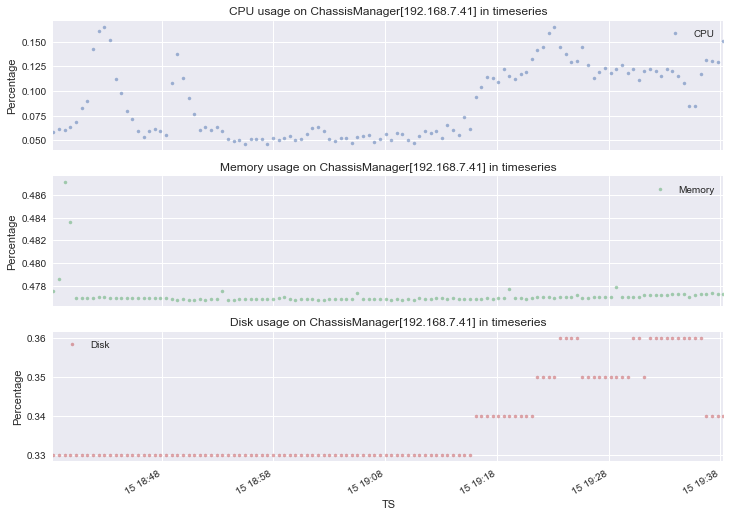

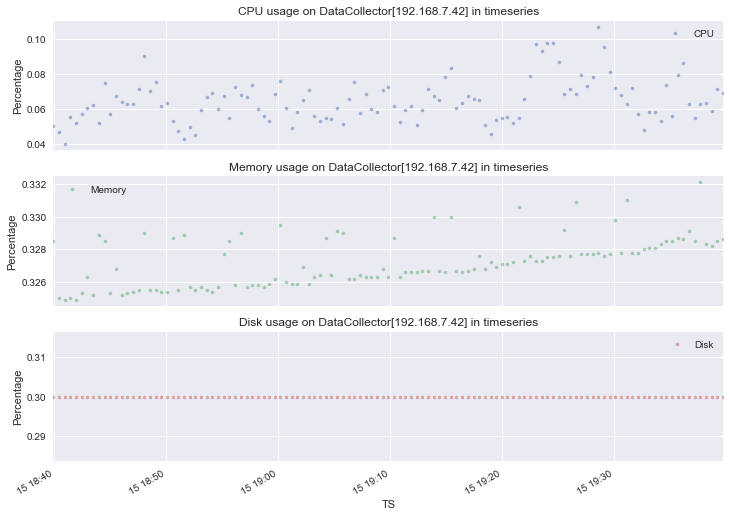

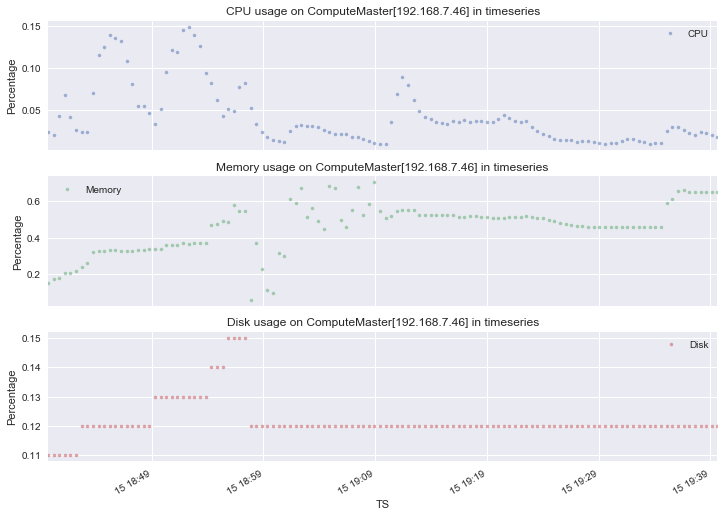

In [5]:
for node_info in NODE_INFO_LIST:
    df = node_performance_analysis(node_info, 'nohup.out', ['CPU', 'Memory', 'Disk'],
                                   draw=True, save=True)

## Service Performance
### Apache Spark Performance

In [6]:
def get_apache_spark_application_raw_data(node_ip):
    """
    Output pandas dataframe:
    Key:
    Columns:
        id                          object
        name                        object
        startTime           datetime64[ns]
        endTime             datetime64[ns]
        lastUpdated         datetime64[ns]
        duration                   float64
        sparkUser                   object
        completed                     bool
        appSparkVersion             object
        endTimeEpoch                 int64
        startTimeEpoch               int64
        lastUpdatedEpoch             int64
    """
    # Get application meta from history server
    url = f'http://{node_ip}:18080/api/v1/applications?limit=5000&status=completed'
    try:
        res = requests.get(url, verify=False)
    except Exception as e:
        print(f"{url}, Error when making get request: {e}")
        raise e

    if res.status_code == 200:
        data_json = json.loads(res.content)
        #print(data_json)
        df = pd.read_json(res.content)
        df = df.set_index('id')
        df = df.explode('attempts')
        df = pd.concat([df.drop(['attempts'], axis=1), df['attempts'].apply(pd.Series)], axis=1)
        for col_name in ['startTime', 'endTime', 'lastUpdated']:
            df[col_name] = pd.to_datetime(df[col_name], format='%Y-%m-%dT%H:%M:%S.%fGMT')
        # duration to minutes
        df['duration'] = df['duration'].apply(lambda x: x/1000/60)
        df = df.reset_index()
        print(df.head(5))
        return df

In [7]:
raw_df = get_apache_spark_application_raw_data('192.168.7.46')

                    id                       name               startTime  \
0  local-1576549553668    spark_kafka_listener.py 2019-12-17 02:25:52.461   
1  local-1576549402414  spark_baseline_monitor.py 2019-12-17 02:23:21.238   
2  local-1576544485808      spark_ddn_analysis.py 2019-12-17 01:01:24.195   
3  local-1576542996349    spark_data_processor.py 2019-12-17 00:36:34.693   
4  local-1576542590674    spark_kafka_listener.py 2019-12-17 00:29:49.115   

                  endTime         lastUpdated   duration sparkUser  completed  \
0 2019-12-17 02:31:34.601 2019-12-17 02:31:34   5.702333      root       True   
1 2019-12-17 02:24:28.239 2019-12-17 02:24:28   1.116683      root       True   
2 2019-12-17 02:23:01.276 2019-12-17 02:23:01  81.618017      root       True   
3 2019-12-17 01:00:57.721 2019-12-17 01:00:57  24.383800      root       True   
4 2019-12-17 00:36:10.009 2019-12-17 00:36:10   6.348233      root       True   

  appSparkVersion   endTimeEpoch  startTimeEpoch  

In [8]:
raw_df.head(5)

,id,name,startTime,endTime,lastUpdated,duration,sparkUser,completed,appSparkVersion,endTimeEpoch,startTimeEpoch,lastUpdatedEpoch
0,local-1576549553668,spark_kafka_listener.py,2019-12-17 02:25:52.461,2019-12-17 02:31:34.601,2019-12-17 02:31:34,5.702333,root,True,2.4.4,1576549894601,1576549552461,1576549894000
1,local-1576549402414,spark_baseline_monitor.py,2019-12-17 02:23:21.238,2019-12-17 02:24:28.239,2019-12-17 02:24:28,1.116683,root,True,2.4.4,1576549468239,1576549401238,1576549468000
2,local-1576544485808,spark_ddn_analysis.py,2019-12-17 01:01:24.195,2019-12-17 02:23:01.276,2019-12-17 02:23:01,81.618017,root,True,2.4.4,1576549381276,1576544484195,1576549381000
3,local-1576542996349,spark_data_processor.py,2019-12-17 00:36:34.693,2019-12-17 01:00:57.721,2019-12-17 01:00:57,24.383800,root,True,2.4.4,1576544457721,1576542994693,1576544457000
4,local-1576542590674,spark_kafka_listener.py,2019-12-17 00:29:49.115,2019-12-17 00:36:10.009,2019-12-17 00:36:10,6.348233,root,True,2.4.4,1576542970009,1576542589115,1576542970000


In [9]:
raw_df.dtypes

id                          object
name                        object
startTime           datetime64[ns]
endTime             datetime64[ns]
lastUpdated         datetime64[ns]
duration                   float64
sparkUser                   object
completed                     bool
appSparkVersion             object
endTimeEpoch                 int64
startTimeEpoch               int64
lastUpdatedEpoch             int64
dtype: object

In [10]:
def service_performance_analysis_apache_spark(raw_df, app_name_list):
    """
    Input:
    Output:
    """
    tb_df = raw_df[raw_df.groupby(['name'])['duration'].transform(max) == raw_df['duration']]
    for index, row in tb_df.iterrows():
        app_name = row['name']
        max_duration = row.duration
        event_log = row.id
        line = f'{app_name} & {max_duration} & {event_log} \\\\'
        print(line.replace('_', '\\_'))
    
    for app_name in app_name_list:
        df = raw_df.loc[raw_df['name'] == app_name]
        df = df.set_index('startTime')
        var_name_list = ['duration']
        title_list= [f'{app_name}, {var_name}' for var_name in var_name_list]
        cnt = len(var_name_list)
        axes = df[var_name_list].plot(marker='o', alpha=0.5, linestyle='None', figsize=(4*cnt, 3*cnt), title=title_list, subplots=True)
        for ax in axes:
            ax.set_ylabel('Minutes')
        clean_app_name = app_name.split('.')[0]
        plt.savefig(f'{clean_app_name}_perf.png')
    return df

spark\_baseline\_monitor.py & 1.2182166666666667 & local-1576542433200 \\
spark\_kafka\_listener.py & 10.964733333333333 & local-1576533496601 \\
spark\_ddn\_analysis.py & 284.57783333333333 & local-1576375721206 \\
spark\_data\_processor.py & 93.16373333333333 & local-1576370105241 \\


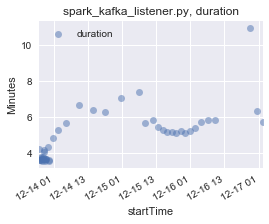

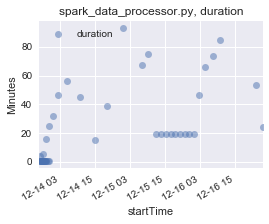

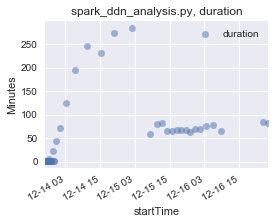

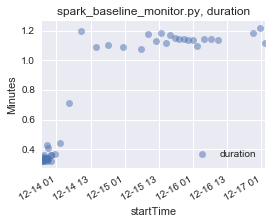

In [11]:
df = service_performance_analysis_apache_spark(raw_df, 
                                               [
                                                   'spark_kafka_listener.py',
                                                   'spark_data_processor.py',
                                                   'spark_ddn_analysis.py',
                                                   'spark_baseline_monitor.py',
                                               ])

In [12]:
df.head(5)

,id,name,endTime,lastUpdated,duration,sparkUser,completed,appSparkVersion,endTimeEpoch,startTimeEpoch,lastUpdatedEpoch
startTime,,,,,,,,,,,
2019-12-17 02:23:21.238,local-1576549402414,spark_baseline_monitor.py,2019-12-17 02:24:28.239,2019-12-17 02:24:28,1.116683,root,True,2.4.4,1576549468239,1576549401238,1576549468000
2019-12-17 00:27:11.321,local-1576542433200,spark_baseline_monitor.py,2019-12-17 00:28:24.414,2019-12-17 00:28:24,1.218217,root,True,2.4.4,1576542504414,1576542431321,1576542504000
2019-12-16 21:55:38.203,local-1576533340046,spark_baseline_monitor.py,2019-12-16 21:56:49.385,2019-12-16 21:56:49,1.186367,root,True,2.4.4,1576533409385,1576533338203,1576533409000
2019-12-16 09:46:05.210,local-1576489566952,spark_baseline_monitor.py,2019-12-16 09:47:13.241,2019-12-16 09:47:13,1.133850,root,True,2.4.4,1576489633241,1576489565210,1576489633000
2019-12-16 07:17:39.450,local-1576480660862,spark_baseline_monitor.py,2019-12-16 07:18:48.218,2019-12-16 07:18:48,1.146133,root,True,2.4.4,1576480728218,1576480659450,1576480728000


### End of File